# CSCI E-89b, Fall 2025

---

**Name:** InJoo Kim

**Due:** September 15, 2025

**Re:** Assignment #1

---

## Problem 1
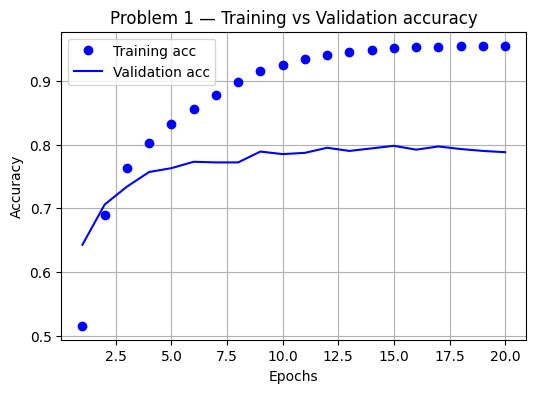

*Val peak:* epoch **15** (val **79.80%**).  
*Test (at epoch 15):* **78.32%**.  
*Fig. 1:* Training/validation accuracy (1–20 epochs).



In [ ]:
# Imports & constants
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.datasets import reuters
from tensorflow.keras.utils import to_categorical

NUM_WORDS  = 10000
NUM_CLASSES = 46
BATCH = 512


In [ ]:
# Load data
(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = reuters.load_data(num_words=NUM_WORDS)

# Vectorize inputs (one-hot)
def vectorize(seqs, dimension=NUM_WORDS):
    X = np.zeros((len(seqs), dimension), dtype="float32")
    for i, s in enumerate(seqs):
        X[i, s] = 1.0
    return X

x_train = vectorize(x_train_raw, NUM_WORDS)
x_test  = vectorize(x_test_raw,  NUM_WORDS)

# One-hot labels
y_train = to_categorical(y_train_raw, NUM_CLASSES)
y_test  = to_categorical(y_test_raw,  NUM_CLASSES)

# Assignment split
x_tr,  y_tr  = x_train[:7982],     y_train[:7982]
x_val, y_val = x_train[7982:8982], y_train[7982:8982]

print("Train:", x_tr.shape, y_tr.shape, "| Val:", x_val.shape, y_val.shape, "| Test:", x_test.shape, y_test.shape)


Train: (7982, 10000) (7982, 46) | Val: (1000, 10000) (1000, 46) | Test: (2246, 10000) (2246, 46)


## Problem 1 — Baseline (64, 64, softmax-46)
### 1A) Build & compile baseline


In [23]:
# Baseline model (64, 64)
model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(NUM_WORDS,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(NUM_CLASSES, activation='softmax'),
])
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_48 (Dense)                │ (None, 64)             │       640,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 46)             │         2,990 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 647,214 (2.47 MB)

 Trainable params: 647,214 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

### 1B) Train long (20 epochs) and plot accuracy


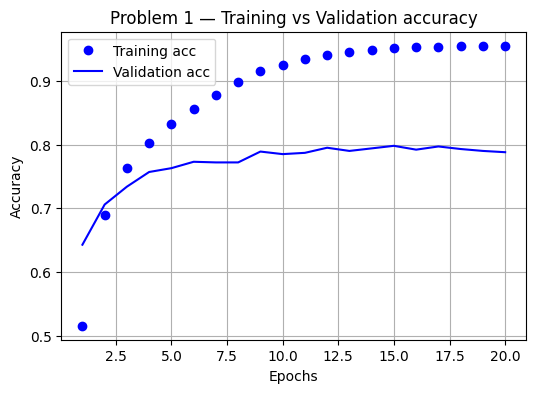

In [ ]:
# Train for 20 epochs to observe curves
history = model.fit(
    x_tr, y_tr,
    epochs=20,
    batch_size=BATCH,
    validation_data=(x_val, y_val),
    verbose=0
)

# Plot accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc)+1)

plt.figure(figsize=(6,4))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b',  label='Validation acc')
plt.title('Problem 1 — Training vs Validation accuracy')
plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)

plt.show()


### 1C) Pick optimal epoch by validation accuracy
- Use argmax of `val_accuracy` (first occurrence).
- Retrain a fresh model for exactly the optimal epochs.
- Evaluate on the held-out test set (2,246).


In [25]:
import numpy as np

# Choose optimal epoch (first peak)
opt_epoch = int(np.argmax(val_acc) + 1)
best_val_acc = float(val_acc[opt_epoch-1])
print(f"[P1] opt_epoch={opt_epoch}, best_val_acc={best_val_acc*100:.2f}%")

# Retrain fresh baseline for opt_epoch
final_baseline = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(NUM_WORDS,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(NUM_CLASSES, activation='softmax'),
])
final_baseline.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
final_baseline.fit(x_tr, y_tr, epochs=opt_epoch, batch_size=BATCH, verbose=0)
test_loss_p1, test_acc_p1 = final_baseline.evaluate(x_test, y_test, verbose=0)
print(f"[P1] test_acc={test_acc_p1*100:.2f}%")


[P1] opt_epoch=15, best_val_acc=79.80%
[P1] test_acc=78.32%


## Problem 2
**(A) (128, 64):** val peak **epoch 8** (val **80.60%**), test **78.85%**.  
**(B) L2=1e−3 (64, 64):** val peak **epoch 15** (val **80.50%**), test **78.01%**.  
*Baseline test:* **78.32%** → (A) **+0.53 pp**, (B) **−0.31 pp**.  
*Figs. 2a–2b:* Accuracy curves.

| Model                 | Opt. epoch | Best val acc | Test acc | Δ vs baseline |
|-----------------------|------------|--------------|----------|---------------|
| Baseline (64, 64)     | 15         | 79.80%       | 78.32%   | —             |
| P2-A (128, 64)        | 8          | 80.60%       | 78.85%   | +0.53 pp      |
| P2-B (L2 = 1e−3)      | 15         | 80.50%       | 78.01%   | −0.31 pp      |


### (A) Wider hidden layers (128, 64)


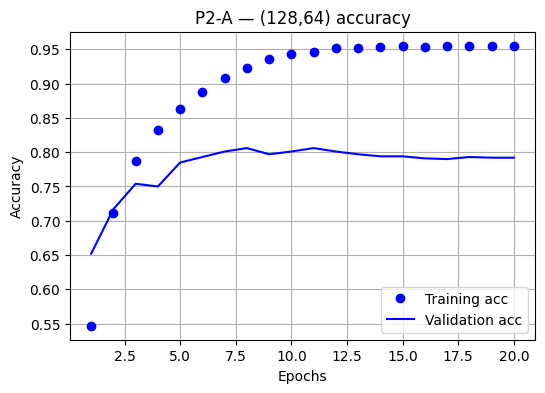

[P2-A] opt_epoch=8, best_val_acc=80.60%, test_acc=78.85%


In [ ]:
# P2-A: Wider hidden layers (128, 64)
from tensorflow.keras import models, layers
import numpy as np
import matplotlib.pyplot as plt

# 1) build & compile
model_A = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(10000,)),
    layers.Dense(64,  activation='relu'),
    layers.Dense(46,  activation='softmax')
])
model_A.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# 2) train 20 epochs to get the curve
hist_A = model_A.fit(x_tr, y_tr, epochs=20, batch_size=512,
                     validation_data=(x_val, y_val), verbose=0)

# 3) plot accuracy
accA  = hist_A.history['accuracy']
valA  = hist_A.history['val_accuracy']
epochs = range(1, len(accA)+1)
plt.figure(figsize=(6,4))
plt.plot(epochs, accA, 'bo', label='Training acc')
plt.plot(epochs, valA, 'b',  label='Validation acc')
plt.title('P2-A — (128,64) accuracy')
plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)

plt.show()

# 4) pick optimal epoch by validation accuracy
optA = int(np.argmax(valA) + 1)
best_val_A = float(valA[optA-1])

# 5) retrain a fresh model exactly for optA epochs, then test
final_A = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(10000,)),
    layers.Dense(64,  activation='relu'),
    layers.Dense(46,  activation='softmax')
])
final_A.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
final_A.fit(x_tr, y_tr, epochs=optA, batch_size=512, verbose=0)
_, testA = final_A.evaluate(x_test, y_test, verbose=0)

print(f"[P2-A] opt_epoch={optA}, best_val_acc={best_val_A*100:.2f}%, test_acc={testA*100:.2f}%")


### (B) L2 regularization (λ = 1e−3)


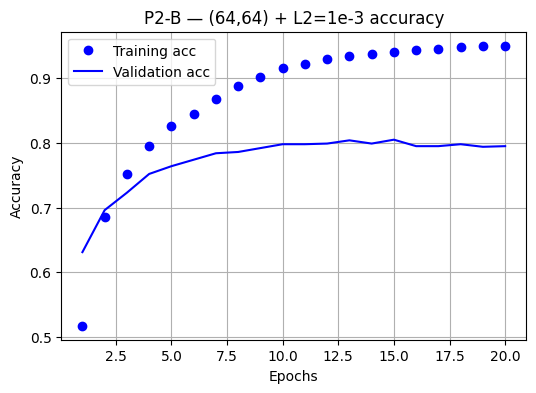

[P2-B] opt_epoch=15, best_val_acc=80.50%, test_acc=78.01%


In [ ]:
# P2-B: L2 regularization (lambda = 1e-3)
from tensorflow.keras import models, layers, regularizers
import numpy as np
import matplotlib.pyplot as plt

# 1) build & compile (L2 on both hidden layers)
model_B = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(10000,),
                 kernel_regularizer=regularizers.l2(1e-3)),
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(1e-3)),
    layers.Dense(46, activation='softmax')
])
model_B.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# 2) train 20 epochs to get the curve
hist_B = model_B.fit(x_tr, y_tr, epochs=20, batch_size=512,
                     validation_data=(x_val, y_val), verbose=0)

# 3) plot accuracy
accB  = hist_B.history['accuracy']
valB  = hist_B.history['val_accuracy']
epochs = range(1, len(accB)+1)
plt.figure(figsize=(6,4))
plt.plot(epochs, accB, 'bo', label='Training acc')
plt.plot(epochs, valB, 'b',  label='Validation acc')
plt.title('P2-B — (64,64) + L2=1e-3 accuracy')
plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)

plt.show()

# 4) pick optimal epoch by validation accuracy
optB = int(np.argmax(valB) + 1)
best_val_B = float(valB[optB-1])

# 5) retrain fresh model for optB epochs, then test
final_B = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(10000,),
                 kernel_regularizer=regularizers.l2(1e-3)),
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(1e-3)),
    layers.Dense(46, activation='softmax')
])
final_B.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
final_B.fit(x_tr, y_tr, epochs=optB, batch_size=512, verbose=0)
_, testB = final_B.evaluate(x_test, y_test, verbose=0)

print(f"[P2-B] opt_epoch={optB}, best_val_acc={best_val_B*100:.2f}%, test_acc={testB*100:.2f}%")


### Summary


In [ ]:
#   opt_epoch, best_val_acc, test_acc_p1
baseline = float(test_acc_p1) * 100.0

print(f"Baseline: test_acc = {baseline:.2f}%")
print(f"P2-A: opt_epoch = {optA}, best_val_acc = {best_val_A*100:.2f}%, test_acc = {testA*100:.2f}%")
print(f"P2-B: opt_epoch = {optB}, best_val_acc = {best_val_B*100:.2f}%, test_acc = {testB*100:.2f}%")

print(f"Δ(P2-A vs baseline) = {testA*100 - baseline:+.2f} pp")
print(f"Δ(P2-B vs baseline) = {testB*100 - baseline:+.2f} pp")


Baseline: test_acc = 78.32%
P2-A: opt_epoch = 8, best_val_acc = 80.60%, test_acc = 78.85%
P2-B: opt_epoch = 15, best_val_acc = 80.50%, test_acc = 78.01%
Δ(P2-A vs baseline) = +0.53 pp
Δ(P2-B vs baseline) = -0.31 pp


## Problem 3 — Optimizers
*Protocol:* train 20 → pick val peak → retrain for that epoch → report.

**Best val per optimizer (Table 1).**
| optimizer | hyperparams    | opt_epoch | best_val_acc |
|-----------|----------------|-----------|--------------|
| RMSprop   | {'lr': 0.0005} | 14        | **0.813**    |
| Adam      | {'lr': 0.001}  | 7         | 0.811        |
| SGD       | {'lr': 0.01}   | 20        | 0.746        |
| Adagrad   | {'lr': 0.01}   | 20        | 0.688        |

*Best model:* **RMSprop (lr=5e−4)** @ **epoch 14**, test **79.61%**.  
*Compare:* vs P1 **+1.29 pp**; vs P2-A **+0.76 pp**; vs P2-B **+1.60 pp**.  
*Figs. 3a–3d:* Best accuracy curves per optimizer.


In [34]:
from tensorflow.keras import models, layers, optimizers
import numpy as np, matplotlib.pyplot as plt, pandas as pd

# Model from Problem 2 (128, 64)
def build_model_p3(input_dim=10000, num_classes=46):
    return models.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_dim,)),
        layers.Dense(64,  activation='relu'),
        layers.Dense(num_classes, activation='softmax'),
    ])

def make_optimizer(name, hp):
    lr = hp.get("lr", 1e-3)
    if name == "RMSprop": return optimizers.RMSprop(learning_rate=lr)
    if name == "Adam":    return optimizers.Adam(learning_rate=lr)
    if name == "SGD":     return optimizers.SGD(learning_rate=lr, momentum=0.9, nesterov=True)
    if name == "Adagrad": return optimizers.Adagrad(learning_rate=lr)
    raise ValueError(name)

def train_20(name, hp, epochs=20, batch=512):
    m = build_model_p3()
    m.compile(optimizer=make_optimizer(name, hp), loss='categorical_crossentropy', metrics=['accuracy'])
    hist = m.fit(x_tr, y_tr, epochs=epochs, batch_size=batch, validation_data=(x_val, y_val), verbose=0)
    return m, hist

def plot_curves(hist, title):
    acc, val_acc = hist.history['accuracy'], hist.history['val_accuracy']
    e = range(1, len(acc)+1)
    plt.figure(figsize=(6,4))
    plt.plot(e, acc, 'bo', label='Training acc'); plt.plot(e, val_acc, 'b', label='Validation acc')
    plt.title(title); plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)
    plt.show()


In [ ]:
grid = {
    "RMSprop": [{"lr": 1e-3}, {"lr": 5e-4}],
    "Adam":    [{"lr": 1e-3}, {"lr": 5e-4}],
    "SGD":     [{"lr": 1e-2}, {"lr": 5e-3}],
    "Adagrad": [{"lr": 1e-2}, {"lr": 1e-3}],
}

best_hist_per_opt = {}
rows = []

for opt_name, hps in grid.items():
    best_val = -1.0
    best_row = None
    best_hist = None
    for hp in hps:
        _, hist = train_20(opt_name, hp)
        val_acc = hist.history['val_accuracy']
        opt_epoch = int(np.argmax(val_acc) + 1)
        best_here = float(val_acc[opt_epoch-1])
        rows.append({"optimizer": opt_name, "hyperparams": hp, "opt_epoch": opt_epoch, "best_val_acc": best_here})
        if best_here > best_val:
            best_val, best_row, best_hist = best_here, {"optimizer": opt_name, "hyperparams": hp, "opt_epoch": opt_epoch, "best_val_acc": best_here}, hist
    best_hist_per_opt[opt_name] = (best_row, best_hist)

df_all = pd.DataFrame(rows)
idx = df_all.groupby("optimizer")["best_val_acc"].idxmax()
summary = df_all.loc[idx].reset_index(drop=True).sort_values("best_val_acc", ascending=False).reset_index(drop=True)
summary  # optimizer, hyperparams, opt_epoch, best_val_acc


/Users/jacobmac/Desktop/Dev/csci89/venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


,optimizer,hyperparams,opt_epoch,best_val_acc
0,RMSprop,{'lr': 0.0005},14,0.813
1,Adam,{'lr': 0.001},7,0.811
2,SGD,{'lr': 0.01},20,0.746
3,Adagrad,{'lr': 0.01},20,0.688


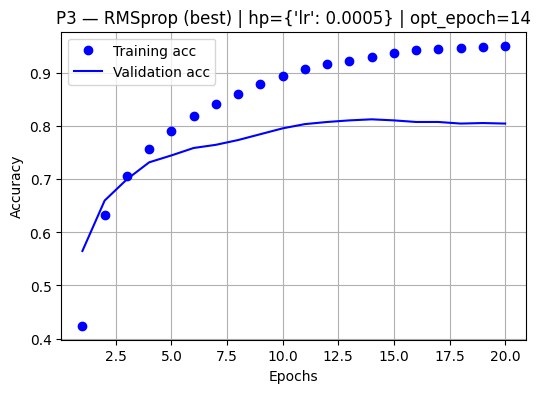

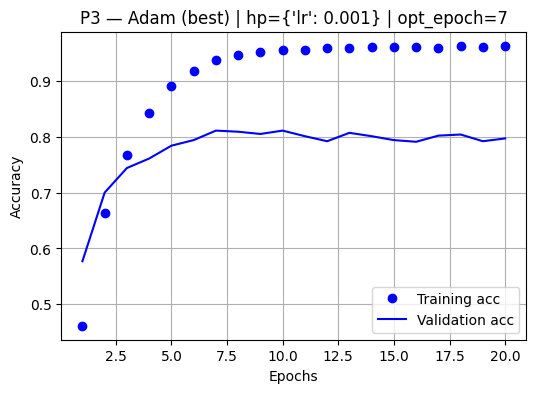

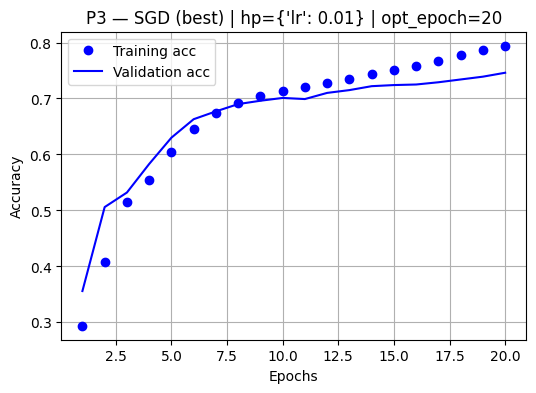

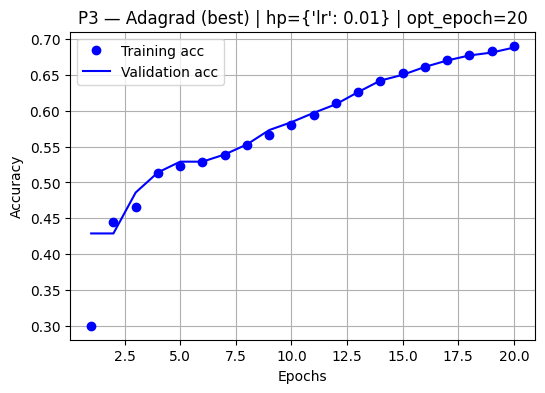

In [36]:
for opt_name in ["RMSprop", "Adam", "SGD", "Adagrad"]:
    best_row, best_hist = best_hist_per_opt[opt_name]
    title = f"P3 — {opt_name} (best) | hp={best_row['hyperparams']} | opt_epoch={best_row['opt_epoch']}"
    plot_curves(best_hist, title)


In [ ]:
# pick single best
best_overall = summary.iloc[0].to_dict()
best_opt, best_hp, best_epoch, best_val = best_overall["optimizer"], best_overall["hyperparams"], int(best_overall["opt_epoch"]), float(best_overall["best_val_acc"])

# retrain for best_epoch and evaluate on test set
m = build_model_p3(); m.compile(optimizer=make_optimizer(best_opt, best_hp), loss='categorical_crossentropy', metrics=['accuracy'])
m.fit(x_tr, y_tr, epochs=best_epoch, batch_size=512, verbose=0)
test_loss_p3, test_acc_p3 = m.evaluate(x_test, y_test, verbose=0)

# Known test accuracies
p1 = float(test_acc_p1)*100 if "test_acc_p1" in globals() else None
p2a = float(testA)*100 if "testA" in globals() else None
p2b = float(testB)*100 if "testB" in globals() else None

print(f"[P3] best optimizer={best_opt}, hp={best_hp}, opt_epoch={best_epoch}, best_val_acc={best_val*100:.2f}%")
print(f"[P3] test_acc={test_acc_p3*100:.2f}%")



[P3] best optimizer=RMSprop, hp={'lr': 0.0005}, opt_epoch=14, best_val_acc=81.30%
[P3] test_acc=79.03%
